In [1]:
import pandas as pd
import geopandas as gp 
import numpy as np 
from pandas import read_csv
import requests
import os


# VEST Documentation

The shapefile used for the 2016 election results was the 2017 wards shapefile. The 2017 wards shapefile featured multiple changes and corrections to the ward boundaries what were already in effect for the November 2016 general election but were not in the January 2016 wards shapefile.

Several thousand votes were reported for the town of Menasha, which had almost entirely been incorporated into the village of Fox Crossing. 

The ward numbers in the Menasha results matched exactly the wards in Fox Crossing that didn't report any results, so the Menasha results were applied to Fox Crossing.

The following wards had been added due to annexations subsequent to the 2016 general election. They were merged back into the 2016 wards along with any associated election results.

Brown: Wrightstown 5
Clark: Abbotsford 7
Dane: DeForest 18, Sun Prairie 22
Eau Claire: Eau Claire 68
Fond du Lac: Fond du Lac 28
Green Lake: Green Lake 4
Kenosha: Kenosha 94
La Crosse: Holmen 12
Manitowoc: Manitowoc 29
Marathon: Wausau 48
Monroe: Tomah 21
Outagamie: Combined Locks 6, Kaukauna 13
Washington: Slinger 9
Waukesha: Sussex 10
Waupaca: Clintonville 9, 10
Winnebago: Menasha 39-42, Neenah 26

These additional changes were made to reflect the 2016 ward-by-ward results.

Grant: Split Platteville 8/9
Jefferson: Renumber Watertown 3 to Watertown 19
La Crosse: Split Holland 1 from Holmen 2
Winnebago: Relabel Fox Crossing 8-13 as Menasha 8-13

Note that the election results for Holland 1-6 and Holmen 1-11 in La Crosse County were reapportioned accordingly using the same whole population methodology as the WI Legislative Technology Services Bureau.


G16PRERTru - Donald J. Trump (Republican Party)
G16PREDCli - Hillary Clinton (Democratic Party)
G16PRECCas - Darrell L. Castle (Constitution Party)
G16PRELJoh - Gary Johnson (Libertarian Party)
G16PREGSte - Jill Stein (Green Party)
G16PREOth - Write-in Votes

G16USSRJoh - Ron Johnson (Republican Party)
G16USSDFei - Russ Feingold (Democratic Party)
G16USSLAnd - Phillip N. Anderson (Libertarian Party)
G16USSOth - Write-in Votes


# Load Files

In [95]:
wards = gp.read_file('./raw-data/WI_20122020_Election_Data_Wards_2017/WI_20122020_Election Data_Wards_2017.shp')
final = gp.read_file('./raw-data/wi_vest_16/wi_vest_16.shp')

#Set options for pandas displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

6872


# Process wards shapefile

In [3]:
# View the shape and columns for the VEST file and the file retrieved from the Wisconsin LTSB

print(final.columns)
print(final.shape)
print(wards.columns)
print(wards.shape)


Index(['OBJECTID_1', 'OBJECTID', 'GEOID', 'MCD_FIPS', 'CNTY_FIPS', 'LSAD',
       'NAME', 'ASM', 'SEN', 'CON', 'COUSUBFP', 'CNTY_NAME', 'STR_WARDS',
       'PERSONS', 'PERSONS18', 'WHITE', 'BLACK', 'HISPANIC', 'ASIAN',
       'AMINDIAN', 'PISLAND', 'OTHER', 'OTHERMLT', 'WHITE18', 'BLACK18',
       'HISPANIC18', 'ASIAN18', 'AMINDIAN18', 'PISLAND18', 'OTHER18',
       'OTHERMLT18', 'G16PRERTRU', 'G16PREDCLI', 'G16PRECCAS', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOTH', 'G16USSRJOH', 'G16USSDFEI', 'G16USSLAND',
       'G16USSOTH', 'geometry'],
      dtype='object')
(6872, 42)
Index(['OBJECTID_1', 'OBJECTID', 'GEOID', 'MCD_FIPS', 'CNTY_FIPS', 'LSAD',
       'NAME', 'ASM', 'SEN', 'CON',
       ...
       'WSSDEM12', 'WSSREP12', 'WSSREP212', 'WSSCON12', 'WSSIND12', 'WSSSCT12',
       'WSSAME12', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object', length=188)
(6895, 188)


In [4]:
# See if all of the fields that are needed are in the wards file

wards_add_col = []
for i in final.columns:
    if '16' not in i:
        if i not in wards.columns:
            print(i, ' needs to be added to wards.')
            wards_add_col.append(i)
if len(wards_add_col)==0:
    print('All the necessary columns exist in the wards file.')
else:
    print('All columns to be added to wards: ', wards_add_col)

All the necessary columns exist in the wards file.


In [5]:
# Get all president and senate candidate options

#All candidates that we know have matching fields in the VEST file
known_cands = ['PRETOT16','USSTOT16','PREREP16','PREDEM16','PRECON16','PRELIB16','PREGRN16','USSREP16','USSDEM16','USSLIB16']
writein_pre = []
writein_sen = []
for i in wards.columns:
    if '16' in i:
        if i not in known_cands:
            if i.startswith('PRE'):
                writein_pre.append(i)
            elif i.startswith('USS'):
                writein_sen.append(i)
                
print(writein_pre)
print('\n')
print(writein_sen)

['PREIND16', 'PREIND216', 'PREIND316', 'PREIND416', 'PREIND516', 'PREIND616', 'PREIND716', 'PREIND816', 'PREIND916', 'PREIND1016', 'PREIND1116', 'PRESCT16']


['USSREP216', 'USSSCT16']


In [6]:
#Fill all NA values to 0

wards = wards.fillna(0)

In [7]:
#Set all types that contain '16' (e.g. election results) as integers

for i in wards.columns:
    if '16' in i:
        wards[i] = wards[i].astype(int)

In [8]:
# Create write-in vote fields for the presidental and US Senate races

wards['G16PREOTH'] = wards.apply(lambda x: sum([x[i] for i in writein_pre]),axis=1)
wards['G16USSOTH'] = wards.apply(lambda x: sum([x[i] for i in writein_sen]),axis=1)

wards.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,CDATOT16,CDADEM16,CDADEM216,CDAREP16,CDAIND16,CDASCT16,PRETOT16,PREDEM16,PREREP16,PREGRN16,PRELIB16,PRECON16,PREIND16,PREIND216,PREIND316,PREIND416,PREIND516,PREIND616,PREIND716,PREIND816,PREIND916,PREIND1016,PREIND1116,PRESCT16,USHTOT16,USHDEM16,USHDEM216,USHREP16,USHGRN16,USHLIB16,USHIND16,USHSCT16,USSTOT16,USSDEM16,USSREP16,USSREP216,USSLIB16,USSSCT16,WSATOT16,WSADEM16,WSAREP16,WSALIB16,WSAIND16,WSASCT16,WSSTOT16,WSSDEM16,WSSREP16,WSSIND16,WSSSCT16,GOVTOT14,GOVDEM14,GOVREP14,GOVREP214,GOVREP314,GOVCON14,GOVIND14,GOVIND214,GOVIND314,GOVIND414,GOVIND514,GOVSCT14,SOSTOT14,SOSDEM14,SOSREP14,SOSCON14,SOSIND14,SOSSCT14,TRSTOT14,TRSDEM14,TRSREP14,TRSCON14,TRSIND14,TRSIND214,TRSSCT14,USHTOT14,USHDEM14,USHREP14,USHREP214,USHIND14,USHIND214,USHSCT14,USSTOT14,USSDEM14,USSREP14,USSIND14,USSSCT14,WAGTOT14,WAGDEM14,WAGREP14,WAGIND14,WAGSCT14,WSATOT14,WSADEM14,WSAREP14,WSAREP214,WSAIND14,WSASCT14,CDATOT12,CDADEM12,CDADEM212,CDAREP12,CDAIND12,CDASCT12,GOVTOT12,GOVDEM12,GOVREP12,GOVIND12,GOVSCT12,PRETOT12,PREDEM12,PREREP12,PRECON12,PREIND12,PREIND212,PREIND312,PREIND412,PREIND512,PREIND612,PRESCT12,USHTOT12,USHDEM12,USHREP12,USHIND12,USHSCT12,USSTOT12,USSDEM12,USSREP12,USSCON12,USSIND12,USSIND212,USSIND312,USSSCT12,WAGTOT12,WAGDEM12,WAGDEM212,WAGREP12,WAGIND12,WAGSCT12,WSATOT12,WSADEM12,WSADEM212,WSAREP12,WSAREP212,WSAIND12,WSAIND212,WSASCT12,WSSTOT12,WSSDEM12,WSSREP12,WSSREP212,WSSCON12,WSSIND12,WSSSCT12,WSSAME12,Shape__Are,Shape__Len,geometry,G16PREOTH,G16USSOTH
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,269,262,0,0,0,7,369,129,219,3,10,4,1,0,0,0,0,0,0,0,0,0,0,3,358,128,0,230,0,0,0,0,366,148,201,0,16,1,358,140,202,0,16,0,0,0,0,0,0,314,118,193,0,0,0,1,2,0,0,0,0,308,139,161,4,4,0,303,124,163,2,5,9,0,310,112,196,0,2,0,0,310,96,214,0,0,309,112,190,7,0,306,124,182,0,0,0,245,0,0,239,6,0,341,136,198,5,2,363,170,186,1,3,0,0,2,0,0,1,352,142,209,0,1,357,171,173,0,7,5,0,1,265,257,0,0,0,8,347,164,0,182,0,0,0,1,0,0,0,0,0,0,0,0,0.000074,0.054695,"POLYGON ((-89.72744 44.78966, -89.72716 44.789...",4,1
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,224,219,0,0,0,5,304,109,179,5,8,2,0,0,0,0,0,0,0,0,0,0,0,1,298,103,0,195,0,0,0,0,301,118,172,0,11,0,295,110,165,0,20,0,0,0,0,0,0,242,92,148,0,0,0,0,2,0,0,0,0,238,107,122,5,4,0,234,94,127,4,4,5,0,240,86,151,0,3,0,0,239,75,164,0,0,237,86,146,5,0,235,97,138,0,0,0,233,0,0,228,5,0,282,110,165,6,1,295,137,153,1,1,0,0,2,0,0,1,289,118,170,0,1,291,134,146,0,7,3,0,1,213,209,0,0,0,4,284,141,0,143,0,0,0,0,0,0,0,0,0,0,0,0,0.000824,0.214674,"POLYGON ((-89.66177 44.80774, -89.65977 44.807...",1,0
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,108,106,0,0,0,2,152,53,87,3,4,1,1,1,0,1,0,0,0,0,0,0,0,1,144,50,0,94,0,0,0,0,146,57,84,0,5,0,146,54,81,0,10,1,0,0,0,0,0,121,46,75,0,0,0,0,0,0,0,0,0,118,53,61,2,2,0,119,48,64,2,2,3,0,120,43,76,0,1,0,0,120,37,83,0,0,120,44,74,2,0,118,49,69,0,0,0,117,0,0,115,2,0,136,54,82,0,0,146,67,75,1,1,0,0,1,0,0,1,140,57,82,0,1,143,65,71,0,4,2,0,1,103,101,0,0,0,2,139,68,0,70,0,0,0,1,0,0,0,0,0,0,0,0,0.001103,0.251395,"POLYGON ((-89.65974 44.78602, -89.64965 44.786...",4,0
3,3004,3004,55073545250001,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0001,778,585,737,4,33,2,1,0,0,1,563,2,16,2,1,0,0,1,305,298,0,0,0,7,455,147,283,3,15,3,0,0,0,2,0,0,0,0,0,0,0,2,438,135,0,302,0,0,0,1,452,153,281,0,17,1,441,147,269,0,24,1,0,0,0,0,0,370,122,245,0,0,0,1,2,0,0,0,0,362,151,199,4,8,0,360,127,203,4,8,18,0,364,113,247,0,4,0,0,365,97,268,0,0,363,124,231,8,0,357,134,223,0,0,0,321,0,0,314,7,0,403,139,257,6,1,440,186,248,2,3,0,0,0,0,0,1,4

In [9]:
# Rename columns to match VEST


rename_dict = {known_cands[2]:'G16PRERTRU',known_cands[3]:'G16PREDCLI',known_cands[4]:'G16PRECCAS',
               known_cands[5]:'G16PRELJOH',known_cands[6]:'G16PREGSTE',
               known_cands[7]:'G16USSRJOH',known_cands[8]:'G16USSDFEI',known_cands[9]:'G16USSLAND'}

wards.rename(columns=rename_dict,inplace=True)

wards.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,CDATOT16,CDADEM16,CDADEM216,CDAREP16,CDAIND16,CDASCT16,PRETOT16,G16PREDCLI,G16PRERTRU,G16PREGSTE,G16PRELJOH,G16PRECCAS,PREIND16,PREIND216,PREIND316,PREIND416,PREIND516,PREIND616,PREIND716,PREIND816,PREIND916,PREIND1016,PREIND1116,PRESCT16,USHTOT16,USHDEM16,USHDEM216,USHREP16,USHGRN16,USHLIB16,USHIND16,USHSCT16,USSTOT16,G16USSDFEI,G16USSRJOH,USSREP216,G16USSLAND,USSSCT16,WSATOT16,WSADEM16,WSAREP16,WSALIB16,WSAIND16,WSASCT16,WSSTOT16,WSSDEM16,WSSREP16,WSSIND16,WSSSCT16,GOVTOT14,GOVDEM14,GOVREP14,GOVREP214,GOVREP314,GOVCON14,GOVIND14,GOVIND214,GOVIND314,GOVIND414,GOVIND514,GOVSCT14,SOSTOT14,SOSDEM14,SOSREP14,SOSCON14,SOSIND14,SOSSCT14,TRSTOT14,TRSDEM14,TRSREP14,TRSCON14,TRSIND14,TRSIND214,TRSSCT14,USHTOT14,USHDEM14,USHREP14,USHREP214,USHIND14,USHIND214,USHSCT14,USSTOT14,USSDEM14,USSREP14,USSIND14,USSSCT14,WAGTOT14,WAGDEM14,WAGREP14,WAGIND14,WAGSCT14,WSATOT14,WSADEM14,WSAREP14,WSAREP214,WSAIND14,WSASCT14,CDATOT12,CDADEM12,CDADEM212,CDAREP12,CDAIND12,CDASCT12,GOVTOT12,GOVDEM12,GOVREP12,GOVIND12,GOVSCT12,PRETOT12,PREDEM12,PREREP12,PRECON12,PREIND12,PREIND212,PREIND312,PREIND412,PREIND512,PREIND612,PRESCT12,USHTOT12,USHDEM12,USHREP12,USHIND12,USHSCT12,USSTOT12,USSDEM12,USSREP12,USSCON12,USSIND12,USSIND212,USSIND312,USSSCT12,WAGTOT12,WAGDEM12,WAGDEM212,WAGREP12,WAGIND12,WAGSCT12,WSATOT12,WSADEM12,WSADEM212,WSAREP12,WSAREP212,WSAIND12,WSAIND212,WSASCT12,WSSTOT12,WSSDEM12,WSSREP12,WSSREP212,WSSCON12,WSSIND12,WSSSCT12,WSSAME12,Shape__Are,Shape__Len,geometry,G16PREOTH,G16USSOTH
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,269,262,0,0,0,7,369,129,219,3,10,4,1,0,0,0,0,0,0,0,0,0,0,3,358,128,0,230,0,0,0,0,366,148,201,0,16,1,358,140,202,0,16,0,0,0,0,0,0,314,118,193,0,0,0,1,2,0,0,0,0,308,139,161,4,4,0,303,124,163,2,5,9,0,310,112,196,0,2,0,0,310,96,214,0,0,309,112,190,7,0,306,124,182,0,0,0,245,0,0,239,6,0,341,136,198,5,2,363,170,186,1,3,0,0,2,0,0,1,352,142,209,0,1,357,171,173,0,7,5,0,1,265,257,0,0,0,8,347,164,0,182,0,0,0,1,0,0,0,0,0,0,0,0,0.000074,0.054695,"POLYGON ((-89.72744 44.78966, -89.72716 44.789...",4,1
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,224,219,0,0,0,5,304,109,179,5,8,2,0,0,0,0,0,0,0,0,0,0,0,1,298,103,0,195,0,0,0,0,301,118,172,0,11,0,295,110,165,0,20,0,0,0,0,0,0,242,92,148,0,0,0,0,2,0,0,0,0,238,107,122,5,4,0,234,94,127,4,4,5,0,240,86,151,0,3,0,0,239,75,164,0,0,237,86,146,5,0,235,97,138,0,0,0,233,0,0,228,5,0,282,110,165,6,1,295,137,153,1,1,0,0,2,0,0,1,289,118,170,0,1,291,134,146,0,7,3,0,1,213,209,0,0,0,4,284,141,0,143,0,0,0,0,0,0,0,0,0,0,0,0,0.000824,0.214674,"POLYGON ((-89.66177 44.80774, -89.65977 44.807...",1,0
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,108,106,0,0,0,2,152,53,87,3,4,1,1,1,0,1,0,0,0,0,0,0,0,1,144,50,0,94,0,0,0,0,146,57,84,0,5,0,146,54,81,0,10,1,0,0,0,0,0,121,46,75,0,0,0,0,0,0,0,0,0,118,53,61,2,2,0,119,48,64,2,2,3,0,120,43,76,0,1,0,0,120,37,83,0,0,120,44,74,2,0,118,49,69,0,0,0,117,0,0,115,2,0,136,54,82,0,0,146,67,75,1,1,0,0,1,0,0,1,140,57,82,0,1,143,65,71,0,4,2,0,1,103,101,0,0,0,2,139,68,0,70,0,0,0,1,0,0,0,0,0,0,0,0,0.001103,0.251395,"POLYGON ((-89.65974 44.78602, -89.64965 44.786...",4,0
3,3004,3004,55073545250001,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0001,778,585,737,4,33,2,1,0,0,1,563,2,16,2,1,0,0,1,305,298,0,0,0,7,455,147,283,3,15,3,0,0,0,2,0,0,0,0,0,0,0,2,438,135,0,302,0,0,0,1,452,153,281,0,17,1,441,147,269,0,24,1,0,0,0,0,0,370,122,245,0,0,0,1,2,0,0,0,0,362,151,199,4,8,0,360,127,203,4,8,18,0,364,113,247,0,4,0,0,365,97,268,0,0,363,124,231,8,0,357,134,223,0,0,0,321,0,0,314,7,0,403,139,257,6,1,440,186,248,2

In [10]:
# Subset the wards data to match the columns in the VEST data

wards = wards[final.columns]

wards.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,geometry
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,219,129,4,10,3,4,201,148,16,1,"POLYGON ((-89.72744 44.78966, -89.72716 44.789..."
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,179,109,2,8,5,1,172,118,11,0,"POLYGON ((-89.66177 44.80774, -89.65977 44.807..."
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,87,53,1,4,3,4,84,57,5,0,"POLYGON ((-89.65974 44.78602, -89.64965 44.786..."
3,3004,3004,55073545250001,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0001,778,585,737,4,33,2,1,0,0,1,563,2,16,2,1,0,0,1,283,147,3,15,3,4,281,153,17,1,"POLYGON ((-89.73299 44.80565, -89.73256 44.804..."
4,3005,3005,55073545250002,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0002,842,632,812,5,10,10,5,0,0,0,618,2,2,7,3,0,0,0,305,158,2,15,3,2,303,164,17,0,"POLYGON ((-89.69059 44.85834, -89.69063 44.857..."


In [11]:
# Determine that the number of columns is the same between the VEST and wards shapefiles

wards_colnum = wards.shape[1]
final_colnum = final.shape[1]
print(wards_colnum)
print(final_colnum)
matching = wards_colnum == final_colnum
print('Are there the same number of columns in the final and wards shapefiles? ', str(matching))

42
42
Are there the same number of columns in the final and wards shapefiles?  True


In [12]:
# Before proceeding with processing, determine that the existing vote totals are the same

'''This function returns a dictionary of election results column names and totals for a dataframe.
Input: pandas dataframe
Output: dictionary with column name as key and the total sum of the column as the value'''

def get_column_totals(df):
    column_totals = [] #list for column sums 
    column_name = [] #list for column names
    for i in df.columns:
        if '16' in i: #only election results in the df
            df[i] = df[i].astype(float) #converts the column to float
            column_name.append(i) #add the column name to list of column names
            col_tot = df[i].sum() #gets the sume of the column
            col_tot = round(col_tot,0) #rounds the column total to nearest whole number
            column_totals.append(col_tot) #adds the column total to the list of column sums
    tot_dict = dict(zip(column_name,column_totals)) #zips the two lists into a dictionary
    return tot_dict #returns the dictionary

In [13]:
# Get the total dictionaries for the wards shapefile and the VEST file and compare

wards_tot = get_column_totals(wards)
final_tot = get_column_totals(final)
matching = wards_tot == final_tot
print(wards_tot)
print(final_tot)
print('\nDo the election result sums match the VEST sums? ', str(matching))

{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}

Do the election result sums match the VEST sums?  True


In [14]:
# Add the County name to both the final and wards shapefiles using the Census API

'''This function uses the Census API to retrieve all of the county names and FIPS for a given state.
Input: State FIPS code as a string.
Output: pandas data frame of county fips and names for the given state.'''
def county_names(state_fips):
    """Inputs: state fips code
    Process: Retrieves a list of counties in the given state from the Census API.  
    Outputs: A list of county fips codes in the state. """
    #uses the fips input into the census api
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)  #uses the fips input to locate the state
    )
    #retrieves the data as a json 
    test = resp.json()
    header, *rows = resp.json()
    #county column is "county"
    county_column_index = header.index("county")
    county_fips = (row[county_column_index] for row in rows) #sequence of counties 
    county_names_index = header.index("NAME")
    county_names = (row[county_names_index] for row in rows) #names of the counties
    county_fips = np.array(list(county_fips)) #make the sets into numpy arrays
    county_names = np.array(list(county_names))
    df = pd.DataFrame({'CNTY_FIPS': county_fips, 'COUNTYNAMES': county_names}) #make pd dataframe of arrays
    df[['COUNTY_NAME','state']] = df.COUNTYNAMES.str.split(",",expand=True)
    del df['state']
    del df['COUNTYNAMES']
    return df  #returns the fips codes of all counties

In [15]:
#Run the function for the Wisconsin

wi_counties = county_names('55')

#Create a County field and delete the old one
wi_counties['CNTY_FIPS'] = wi_counties['CNTY_FIPS'].apply(lambda x: ''.join(['55',x]))
wi_counties['COUNTY'] = wi_counties.apply(lambda x: x['COUNTY_NAME'][:-7], axis = 1)
del wi_counties['COUNTY_NAME']

In [16]:
#View the retrieved dataset
wi_counties.head()

,CNTY_FIPS,COUNTY
0,55045,Green
1,55047,Green Lake
2,55049,Iowa
3,55051,Iron
4,55053,Jackson


In [17]:
#Merge the dataset with the wards shapefile
wards_co = pd.merge(wards,wi_counties, on=['CNTY_FIPS'])
#Merge the dataset with the wards shapefile
wards_co.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,geometry,COUNTY
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,219.0,129.0,4.0,10.0,3.0,4.0,201.0,148.0,16.0,1.0,"POLYGON ((-89.72744 44.78966, -89.72716 44.789...",Marathon
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,179.0,109.0,2.0,8.0,5.0,1.0,172.0,118.0,11.0,0.0,"POLYGON ((-89.66177 44.80774, -89.65977 44.807...",Marathon
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,87.0,53.0,1.0,4.0,3.0,4.0,84.0,57.0,5.0,0.0,"POLYGON ((-89.65974 44.78602, -89.64965 44.786...",Marathon
3,3004,3004,55073545250001,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0001,778,585,737,4,33,2,1,0,0,1,563,2,16,2,1,0,0,1,283.0,147.0,3.0,15.0,3.0,4.0,281.0,153.0,17.0,1.0,"POLYGON ((-89.73299 44.80565, -89.73256 44.804...",Marathon
4,3005,3005,55073545250002,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0002,842,632,812,5,10,10,5,0,0,0,618,2,2,7,3,0,0,0,305.0,158.0,2.0,15.0,3.0,2.0,303.0,164.0,17.0,0.0,"POLYGON ((-89.69059 44.85834, -89.69063 44.857...",Marathon


In [18]:
#Merge the dataset with the final shapefile
final = pd.merge(final,wi_counties,on='CNTY_FIPS')
final.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,geometry,COUNTY
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,219.0,129.0,4.0,10.0,3.0,4.0,201.0,148.0,16.0,1.0,"POLYGON ((-89.72744 44.78966, -89.72716 44.789...",Marathon
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,179.0,109.0,2.0,8.0,5.0,1.0,172.0,118.0,11.0,0.0,"POLYGON ((-89.66177 44.80774, -89.65977 44.807...",Marathon
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,87.0,53.0,1.0,4.0,3.0,4.0,84.0,57.0,5.0,0.0,"POLYGON ((-89.65974 44.78602, -89.64965 44.786...",Marathon
3,3004,3004,55073545250001,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0001,778,585,737,4,33,2,1,0,0,1,563,2,16,2,1,0,0,1,283.0,147.0,3.0,15.0,3.0,4.0,281.0,153.0,17.0,1.0,"POLYGON ((-89.73299 44.80565, -89.73256 44.804...",Marathon
4,3005,3005,55073545250002,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0002,842,632,812,5,10,10,5,0,0,0,618,2,2,7,3,0,0,0,305.0,158.0,2.0,15.0,3.0,2.0,303.0,164.0,17.0,0.0,"POLYGON ((-89.69059 44.85834, -89.69063 44.857...",Marathon


In [19]:
# Make a field that contains the precinct municipal name and ward ID

wards_co['NAME'] = wards_co['NAME'].astype(str)
wards_co['COUNTY'] = wards_co['COUNTY'].astype(str)
wards_co['MUN_WARD'] = wards_co.apply(lambda x: '_'.join([x['NAME'],x['STR_WARDS']]),axis=1)
wards_co.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,geometry,COUNTY,MUN_WARD
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,219.0,129.0,4.0,10.0,3.0,4.0,201.0,148.0,16.0,1.0,"POLYGON ((-89.72744 44.78966, -89.72716 44.789...",Marathon,Mosinee_0005
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,179.0,109.0,2.0,8.0,5.0,1.0,172.0,118.0,11.0,0.0,"POLYGON ((-89.66177 44.80774, -89.65977 44.807...",Marathon,Mosinee_0006
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,87.0,53.0,1.0,4.0,3.0,4.0,84.0,57.0,5.0,0.0,"POLYGON ((-89.65974 44.78602, -89.64965 44.786...",Marathon,Mosinee_0007
3,3004,3004,55073545250001,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0001,778,585,737,4,33,2,1,0,0,1,563,2,16,2,1,0,0,1,283.0,147.0,3.0,15.0,3.0,4.0,281.0,153.0,17.0,1.0,"POLYGON ((-89.73299 44.80565, -89.73256 44.804...",Marathon,Mosinee_0001
4,3005,3005,55073545250002,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0002,842,632,812,5,10,10,5,0,0,0,618,2,2,7,3,0,0,0,305.0,158.0,2.0,15.0,3.0,2.0,303.0,164.0,17.0,0.0,"POLYGON ((-89.69059 44.85834, -89.69063 44.857...",Marathon,Mosinee_0002


,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,geometry,COUNTY,MUN_WARD
1693,614,614,55019001000007,5501900100,55019,25,Abbotsford,0,0,0,00100,0,0007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-90.33671 44.94474, -90.33671 ...",Clark,Abbotsford_0007


<AxesSubplot:>

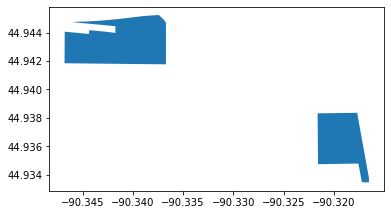

In [20]:
# Modify Abbotsford to fit VESTs Documentation
# Clark: Abbotsford 7
abbotsford = wards_co[wards_co['MUN_WARD']=='Abbotsford_0007'].copy()
display(abbotsford)
abbotsford.plot()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,geometry
0,614,614,55019001000007,5501900100,55019,25,Abbotsford,0,0,0,00100,0,0007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Clark,Abbotsford_0007,"POLYGON ((-90.33671 44.94474, -90.33671 44.943..."
1,614,614,55019001000007,5501900100,55019,25,Abbotsford,0,0,0,00100,0,0007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Clark,Abbotsford_0007,"POLYGON ((-90.31652 44.93379, -90.31652 44.933..."


<AxesSubplot:>

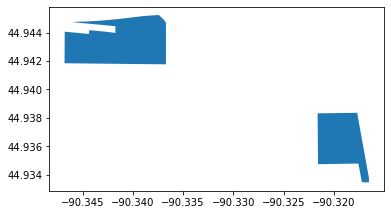

In [21]:
# VEST did not write down what these precincts were merged with, so this was determined from examining the data in QGIS. 
# After examining the data, it appears as though half of Abbotsford 7 is merged with Colby 1 and the other half with Colby 2

# Explod the Abbotsford 7 data and view

exploded = abbotsford.explode()
exploded = exploded.reset_index(drop=True)
display(exploded)
exploded.plot()

<AxesSubplot:>

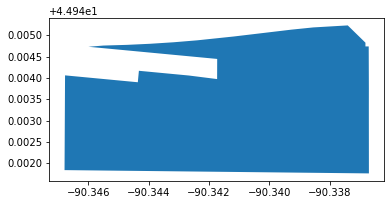

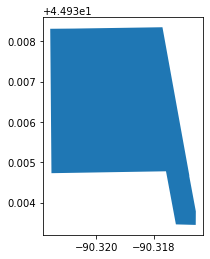

In [22]:
# Assign each ward to their own variable and view to determine which matches with Colby 1 and which matches with Colby 2

ab1 = exploded.loc[0:0]
ab2 = exploded.loc[1:1]
ab1.plot()
ab2.plot()

In [23]:
# After looking at the plots, ab1 should be assigned to Colby 2 and ab2 should be assigned Colby 1 (again, based on examination in QGIS)
ab1['MUN_WARD'] = ['Abbotsford_Colby2']
ab2['MUN_WARD'] = ['Abbotsford_Colby1']

C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [24]:
# Remove the original Abbotsford 7 precinct from the wards file, and add the ab1 and ab2 wards back

proj = wards.crs
wards_drop_ab = wards_co[~wards_co['MUN_WARD'].isin(['Abbotsford_0007'])].copy()
wards_add_ab = gp.GeoDataFrame(pd.concat([ab1,ab2,wards_drop_ab]),crs=proj)
wards_add_ab.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,geometry
0,614,614,55019001000007,5501900100,55019,25,Abbotsford,0,0,0,00100,0,0007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Clark,Abbotsford_Colby2,"POLYGON ((-90.33671 44.94474, -90.33671 44.943..."
1,614,614,55019001000007,5501900100,55019,25,Abbotsford,0,0,0,00100,0,0007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Clark,Abbotsford_Colby1,"POLYGON ((-90.31652 44.93379, -90.31652 44.933..."
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,219.0,129.0,4.0,10.0,3.0,4.0,201.0,148.0,16.0,1.0,Marathon,Mosinee_0005,"POLYGON ((-89.72744 44.78966, -89.72716 44.789..."
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,179.0,109.0,2.0,8.0,5.0,1.0,172.0,118.0,11.0,0.0,Marathon,Mosinee_0006,"POLYGON ((-89.66177 44.80774, -89.65977 44.807..."
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,87.0,53.0,1.0,4.0,3.0,4.0,84.0,57.0,5.0,0.0,Marathon,Mosinee_0007,"POLYGON ((-89.65974 44.78602, -89.64965 44.786..."


In [25]:
# Dissolve precincts to match the documentation in the VEST file

'''The function takes two rows in a geodataframe and merges them into one geometry.
Inputs: Parish name (string), precinct 1 name (string), precinct 2 name (string)
Optional Inputs: rename (string), gdf (geopandas gdf), parish_col (string), vtd_col (where the precinct names are pulled from, string), and precinct_col (field that is manipulated, string)
Output: geodataframe of the dissolved precincts
'''
def precincts_for_dissolve(county, prec1, prec2, gdf, cousubfp='', reverse = '',geoid_col = 'GEOID',agg_func = 'sum', cousubfp_col = 'COUSUBFP', co_col = 'COUNTY', wards_col = 'MUN_WARD'):
    co_gdf = gdf[(gdf[co_col]==county)] #subsets input df to just precincts in the input parish
    dissolve_gdf = co_gdf[(co_gdf[wards_col]==prec1) | (co_gdf[wards_col]==prec2)].copy() #subsets the parish df to be just the two rows that need to be merge
    if cousubfp != '':
        if reverse == '':
            dissolve_gdf = dissolve_gdf[(dissolve_gdf[cousubfp_col]==cousubfp) |(co_gdf[wards_col]==prec2)].copy()
        else:
            dissolve_gdf = dissolve_gdf[(dissolve_gdf[cousubfp_col]==cousubfp) |(co_gdf[wards_col]==prec1)].copy()
    geoids = list(dissolve_gdf['GEOID'])
    prec1_gdf = dissolve_gdf[dissolve_gdf[wards_col]==prec1].copy()
    objectid = list(prec1_gdf['OBJECTID'])
    lsad = list(prec1_gdf['LSAD'])
    cnty_fips = list(prec1_gdf['CNTY_FIPS'])
    geoid = list(prec1_gdf['GEOID'])
    mcd_fips = list(prec1_gdf['MCD_FIPS'])
    asm = list(prec1_gdf['ASM'])
    sen = list(prec1_gdf['SEN'])
    con = list(prec1_gdf['CON'])
    print(len(dissolve_gdf), ' wards are being disolved for ', prec1, prec2)
    wards_list = dissolve_gdf[wards_col]    
    dissolve_gdf = dissolve_gdf.dissolve(by=co_col,aggfunc = agg_func) #first
    dissolve_gdf[co_col] = county
    dissolve_gdf[wards_col] = prec1
    dissolve_gdf['STR_WARDS'] = dissolve_gdf[wards_col].apply(lambda x: x.split('_')[1])
    dissolve_gdf['NAME'] = dissolve_gdf[wards_col].apply(lambda x: x.split('_')[0])
    dissolve_gdf['CNTY_NAME'] = dissolve_gdf[co_col]
    dissolve_gdf['OBJECTID'] = objectid
    dissolve_gdf['OBJECTID_1'] = objectid
    dissolve_gdf['LSAD']=lsad
    dissolve_gdf['CNTY_FIPS'] = cnty_fips
    dissolve_gdf['GEOID'] = geoid
    dissolve_gdf['MCD_FIPS'] = mcd_fips
    dissolve_gdf['ASM'] = asm
    dissolve_gdf['SEN'] = sen
    dissolve_gdf['CON'] = con
    dissolve_gdf['COUSUBFP'] = dissolve_gdf['MCD_FIPS'].apply(lambda x: x[-5:])
    dissolve_gdf = dissolve_gdf.reset_index(drop=True)
    print('Dissolve finished for ',prec1, prec2)
    return dissolve_gdf,geoids #returns a geodataframe with one row: the dissolved geometries of the two rows

In [26]:
# Merge the precincts that VEST documented. Determining which wards to join with was done by examining the data in QGIS.

wrightstown = precincts_for_dissolve('Brown','Wrightstown_0001','Wrightstown_0005',wards_add_ab,'89175')
deforest = precincts_for_dissolve('Dane','Vienna_0002','DeForest_0018',wards_add_ab)
sun_prairie = precincts_for_dissolve('Dane', 'Bristol_0001','Sun Prairie_0022',wards_add_ab)
eau_claire = precincts_for_dissolve('Eau Claire','Union_0003','Eau Claire_0068',wards_add_ab)
fond_du_lac = precincts_for_dissolve('Fond du Lac','Fond du Lac_0001','Fond du Lac_0028',wards_add_ab,'26300')
green_lake = precincts_for_dissolve('Green Lake','Brooklyn_0001','Green Lake_0004',wards_add_ab)
kenosha = precincts_for_dissolve('Kenosha','Somers_0001','Kenosha_0094',wards_add_ab,'74650')
holmen = precincts_for_dissolve('La Crosse','Onalaska_0001','Holmen_0012',wards_add_ab,'59950')
manitowoc = precincts_for_dissolve('Manitowoc','Manitowoc Rapids_0004','Manitowoc_0029',wards_add_ab)
wausau = precincts_for_dissolve('Marathon','Stettin_0002','Wausau_0048',wards_add_ab)
tomah = precincts_for_dissolve('Monroe','Tomah_0001','Tomah_0021',wards_add_ab,'80100')
combined_locks = precincts_for_dissolve('Outagamie','Buchanan_0003','Combined Locks_0006',wards_add_ab)
kaukauna = precincts_for_dissolve('Outagamie','Buchanan_0002','Kaukauna_0013',wards_add_ab)
slinger = precincts_for_dissolve('Washington','Hartford_0005','Slinger_0009',wards_add_ab,'33025')
sussex = precincts_for_dissolve('Waukesha','Lisbon_0002','Sussex_0010',wards_add_ab)
menasha_39 = precincts_for_dissolve('Winnebago','Fox Crossing_0010','Menasha_0039',wards_add_ab)
neenah = precincts_for_dissolve('Winnebago','Neenah_0003','Neenah_0026',wards_add_ab,'55775')
abbotsford1 = precincts_for_dissolve('Clark','Colby_0001','Abbotsford_Colby1',wards_add_ab)
abbotsford2 = precincts_for_dissolve('Clark','Colby_0002','Abbotsford_Colby2',wards_add_ab,'16175')

# There were also two merges that appear to have occured that VEST did not specify
menasha_9 = precincts_for_dissolve('Winnebago','Fox Crossing_0009','Menasha_0009',wards_add_ab,'50850','reverse')
menasha_13 = precincts_for_dissolve('Winnebago','Fox Crossing_0013','Menasha_0013',wards_add_ab,'50850','reverse')


C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


2  wards are being disolved for  Wrightstown_0001 Wrightstown_0005
Dissolve finished for  Wrightstown_0001 Wrightstown_0005
2  wards are being disolved for  Vienna_0002 DeForest_0018
Dissolve finished for  Vienna_0002 DeForest_0018
2  wards are being disolved for  Bristol_0001 Sun Prairie_0022
Dissolve finished for  Bristol_0001 Sun Prairie_0022
2  wards are being disolved for  Union_0003 Eau Claire_0068
Dissolve finished for  Union_0003 Eau Claire_0068
2  wards are being disolved for  Fond du Lac_0001 Fond du Lac_0028
Dissolve finished for  Fond du Lac_0001 Fond du Lac_0028
2  wards are being disolved for  Brooklyn_0001 Green Lake_0004
Dissolve finished for  Brooklyn_0001 Green Lake_0004
2  wards are being disolved for  Somers_0001 Kenosha_0094
Dissolve finished for  Somers_0001 Kenosha_0094
2  wards are being disolved for  Onalaska_0001 Holmen_0012


C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


Dissolve finished for  Onalaska_0001 Holmen_0012
2  wards are being disolved for  Manitowoc Rapids_0004 Manitowoc_0029
Dissolve finished for  Manitowoc Rapids_0004 Manitowoc_0029
2  wards are being disolved for  Stettin_0002 Wausau_0048
Dissolve finished for  Stettin_0002 Wausau_0048
2  wards are being disolved for  Tomah_0001 Tomah_0021
Dissolve finished for  Tomah_0001 Tomah_0021
2  wards are being disolved for  Buchanan_0003 Combined Locks_0006
Dissolve finished for  Buchanan_0003 Combined Locks_0006
2  wards are being disolved for  Buchanan_0002 Kaukauna_0013
Dissolve finished for  Buchanan_0002 Kaukauna_0013
2  wards are being disolved for  Hartford_0005 Slinger_0009


C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


Dissolve finished for  Hartford_0005 Slinger_0009
2  wards are being disolved for  Lisbon_0002 Sussex_0010
Dissolve finished for  Lisbon_0002 Sussex_0010
2  wards are being disolved for  Fox Crossing_0010 Menasha_0039
Dissolve finished for  Fox Crossing_0010 Menasha_0039
2  wards are being disolved for  Neenah_0003 Neenah_0026
Dissolve finished for  Neenah_0003 Neenah_0026
2  wards are being disolved for  Colby_0001 Abbotsford_Colby1
Dissolve finished for  Colby_0001 Abbotsford_Colby1
2  wards are being disolved for  Colby_0002 Abbotsford_Colby2
Dissolve finished for  Colby_0002 Abbotsford_Colby2
2  wards are being disolved for  Fox Crossing_0009 Menasha_0009
Dissolve finished for  Fox Crossing_0009 Menasha_0009
2  wards are being disolved for  Fox Crossing_0013 Menasha_0013
Dissolve finished for  Fox Crossing_0013 Menasha_0013


C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [27]:
#Add all of the dissolved gdfs to a list

prec2replace = [wrightstown[0],deforest[0],sun_prairie[0],eau_claire[0],fond_du_lac[0],green_lake[0],
                kenosha[0],holmen[0],manitowoc[0],wausau[0],tomah[0],combined_locks[0],kaukauna[0],
                slinger[0],sussex[0],menasha_39[0],neenah[0],
                abbotsford1[0],abbotsford2[0],menasha_9[0],menasha_13[0]]

#assign proj to the crs of the original file
proj = wards.crs
#concatonate the geodataframes into one geodataframe
prec2replace = gp.GeoDataFrame(pd.concat(prec2replace, ignore_index=True), crs = proj)
print('There are ', prec2replace.shape[0],' wards that are dissolved to be added back')

There are  21  wards that are dissolved to be added back


In [28]:
#Remove the original precincts from the wards dataset

'''The function takes dictionary of parishes and precincts and drops those from the geodataframe.
Input: dictionary of parishes and precincts
Option Input: parish column, vtd column
Output: geodataframe with dropped precincts'''
def drop_cases(drop_data_dict, gdf, co_col = 'COUNTY', wards_col = 'GEOID'):
    proj = gdf.crs
    print('gdf shape before any alteration: ', gdf.shape)
    for k,v in drop_data_dict.items():
        co_gdf = gdf[(gdf[co_col]==k)]
        gdf = gdf.drop(co_gdf.index)
        gdf.reset_index(drop=True,inplace=True)
        #print('gdf shape after dropping ', k, ' ', gdf.shape)
        #for i in v:
        #    parish_gdf = parish_gdf.drop(parish_gdf[(gdf[vtd_col] == i)].index)
        not_added = co_gdf[co_gdf[wards_col].isin(v)]
        #print('removed precincts from the dataframe: ', list(not_added[vtd_col]))
        co_gdf = co_gdf[~co_gdf[wards_col].isin(v)]
        #print('precincts staying in the df form the parish: ', list(parish_gdf[vtd_col]))
        gdf = gp.GeoDataFrame(pd.concat([gdf,co_gdf],ignore_index=True), crs = proj)
        #print('gdf shape after adding back ', k, ' and dropping merged precincts ', gdf.shape)
    return gdf

In [29]:
drop_data_dict = {'Brown':wrightstown[1],
                 'Dane':deforest[1]+sun_prairie[1],
                 'Eau Claire':eau_claire[1],
                 'Fond du Lac':fond_du_lac[1],
                 'Green Lake':green_lake[1],
                 'Kenosha':kenosha[1],
                 'La Crosse':holmen[1],
                 'Manitowoc':manitowoc[1],
                 'Marathon':wausau[1],
                 'Monroe':tomah[1],
                 'Outagamie':combined_locks[1]+kaukauna[1],
                 'Washington':slinger[1],
                 'Waukesha':sussex[1],
                 'Winnebago':menasha_39[1]+neenah[1]+menasha_9[1]+menasha_13[1],
                 'Clark':abbotsford1[1]+abbotsford2[1]}

#drop the precincts
wards_dropped = drop_cases(drop_data_dict,wards_add_ab)
print('There are ', wards_dropped.shape[0], ' precincts after dropping the cases to be removed. After adding in the merged cases there should be ', wards_dropped.shape[0]+prec2replace.shape[0])

match_val1 = wards_dropped.shape[0]+prec2replace.shape[0]

gdf shape before any alteration:  (6896, 44)
There are  6854  precincts after dropping the cases to be removed. After adding in the merged cases there should be  6875


In [30]:
#Add the precincts back

wards_added = gp.GeoDataFrame(pd.concat([wards_dropped,prec2replace],ignore_index=True), crs=proj)
print('There are ', wards_added.shape[0], ' after adding back the precincts.')

match_val2 = wards_added.shape[0]

matching = match_val1 == match_val2

print('\nAre there the expected number of wards in the file? ', str(matching))

There are  6875  after adding back the precincts.

Are there the expected number of wards in the file?  True


In [31]:
# There are also several wards in the shapefile that need to be merged together to match the VEST file (more than 2:1, which we have already done).

#Merge Clintonville 9 and Larrabee 1
clintonville1 = precincts_for_dissolve('Waupaca','Larrabee_0001','Clintonville_0009',wards_added)

#Remove the Clintonville 9 and Larrabee 1 GEOIDs from Wards
wards_drop_cl9 = wards_added[~wards_added['MUN_WARD'].isin(['Larrabee_0001','Clintonville_0009'])]

#Add the new data back
wards_add_cl9 = gp.GeoDataFrame(pd.concat([clintonville1[0],wards_drop_cl9]),crs=proj)

#Merge Clintonville 10 and Larrabee 1
clintonville2 = precincts_for_dissolve('Waupaca','Larrabee_0001','Clintonville_0010',wards_add_cl9)

2  wards are being disolved for  Larrabee_0001 Clintonville_0009
Dissolve finished for  Larrabee_0001 Clintonville_0009
2  wards are being disolved for  Larrabee_0001 Clintonville_0010
Dissolve finished for  Larrabee_0001 Clintonville_0010


In [32]:
#Merge Menasha 40 and Menasha 8
menasha_40 = precincts_for_dissolve('Winnebago','Fox Crossing_0008','Menasha_0040',wards_add_cl9)

#Remove Menasha 8 and Menasha 40 GEOIDs from Wards
wards_drop_m40 = wards_add_cl9[~wards_add_cl9['MUN_WARD'].isin(['Fox Crossing_0008','Menasha_0040'])]

#Add the new merged wards back
wards_add_m40 = gp.GeoDataFrame(pd.concat([menasha_40[0],wards_drop_m40]),crs=proj)

#Merge Menasha 41 and Menasha 8
menasha_41 = precincts_for_dissolve('Winnebago','Fox Crossing_0008','Menasha_0041',wards_add_m40)

#Remove Menasha 8 and Menasha 41 GEOIDs from Wards
wards_drop_m41 = wards_add_m40[~wards_add_m40['MUN_WARD'].isin(['Fox Crossing_0008','Menasha_0041'])]

#Add the new merged wards back
wards_add_m41 = gp.GeoDataFrame(pd.concat([menasha_41[0],wards_drop_m41]),crs=proj)

#Merge Menasha 41 and Menasha 8
menasha_42 = precincts_for_dissolve('Winnebago','Fox Crossing_0008','Menasha_0042',wards_add_m41)

2  wards are being disolved for  Fox Crossing_0008 Menasha_0040
Dissolve finished for  Fox Crossing_0008 Menasha_0040
2  wards are being disolved for  Fox Crossing_0008 Menasha_0041
Dissolve finished for  Fox Crossing_0008 Menasha_0041
2  wards are being disolved for  Fox Crossing_0008 Menasha_0042
Dissolve finished for  Fox Crossing_0008 Menasha_0042


,geometry,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP
0,"POLYGON ((-88.44496 44.21618, -88.44503 44.216...",6612,6612,1443,1133,1222,9,178,20,14,0,0,0,1015,5,89,14,10,0,0,0,252.0,180.0,4.0,26.0,5.0,9.0,278.0,173.0,18.0,0.0,Winnebago,Fox Crossing_0008,0008,Fox Crossing,Winnebago,47,55139,55139269820008,5513926982,0,0,0,26982


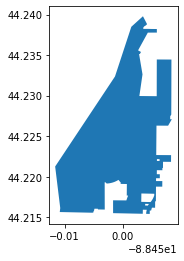

In [33]:
menasha_40[0].plot()
display(menasha_40[0])

In [34]:
#Add the final merged wards to a list
prec2replace = [clintonville2[0],menasha_42[0]]

#Concatonate the geodataframes into one geodataframe
prec2replace = gp.GeoDataFrame(pd.concat(prec2replace, ignore_index=True), crs = proj)
print('There are ', prec2replace.shape[0],' precincts that are dissolved to be added back')

There are  2  precincts that are dissolved to be added back


In [35]:
#Remove the data from the wards file
wards_drop_cl10_m42 = wards_add_m41[~wards_add_m41['GEOID'].isin(clintonville2[1]+menasha_42[1])]

print('There are ', wards_drop_cl10_m42.shape[0], ' precincts after dropping the cases to be removed. After adding in the merged cases there should be ', wards_drop_cl10_m42.shape[0]+prec2replace.shape[0])

match_val1 = wards_drop_cl10_m42.shape[0]+prec2replace.shape[0]

There are  6868  precincts after dropping the cases to be removed. After adding in the merged cases there should be  6870


In [36]:
#Add the precincts back
wards_add_cl10_m42 = gp.GeoDataFrame(pd.concat([wards_drop_cl10_m42,prec2replace],ignore_index=True), crs=proj)
print('There are ', wards_add_cl10_m42.shape[0], ' after adding back the precincts.')

match_val2 = wards_add_cl10_m42.shape[0]

matching = match_val1 == match_val2

print('\nAre there the expected number of wards in the file? ', str(matching))

There are  6870  after adding back the precincts.

Are there the expected number of wards in the file?  True


In [37]:
# After doing this processing, check the vote totals again to make sure no data is missing

# Get the total dictionaries for the elec data and the VEST data and compare

wards_tot = get_column_totals(wards_add_cl10_m42)
final_tot = get_column_totals(final)
matching = wards_tot == final_tot
print(wards_tot)
print(final_tot)
print('Do the election result sums match the VEST sums? ', str(matching))

{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
Do the election result sums match the VEST sums?  True


In [38]:
# Per VESTs documentation, split Holland 1 from Holmen 2

holmen2 = wards_add_cl10_m42[wards_add_cl10_m42['MUN_WARD']=='Holmen_0002'].copy()
display(holmen2)

,geometry,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP
5404,"MULTIPOLYGON (((-91.27288 43.97377, -91.27286 ...",2605,2605,1141,820,1046,15,7,66,6,1,0,0,775,6,3,34,2,0,0,0,271.0,277.0,3.0,23.0,6.0,6.0,272.0,287.0,21.0,0.0,La Crosse,Holmen_0002,0002,Holmen,La Crosse,47,55063,55063354500002,5506335450,94,32,3,35450


,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry
0,2605,2605,1141,820,1046,15,7,66,6,1,0,0,775,6,3,34,2,0,0,0,271.0,277.0,3.0,23.0,6.0,6.0,272.0,287.0,21.0,0.0,La Crosse,Holmen_0002,0002,Holmen,La Crosse,47,55063,55063354500002,5506335450,94,32,3,35450,"POLYGON ((-91.27288 43.97377, -91.27286 43.971..."
1,2605,2605,1141,820,1046,15,7,66,6,1,0,0,775,6,3,34,2,0,0,0,271.0,277.0,3.0,23.0,6.0,6.0,272.0,287.0,21.0,0.0,La Crosse,Holmen_0002,0002,Holmen,La Crosse,47,55063,55063354500002,5506335450,94,32,3,35450,"POLYGON ((-91.27616 43.96290, -91.27611 43.959..."


<AxesSubplot:>

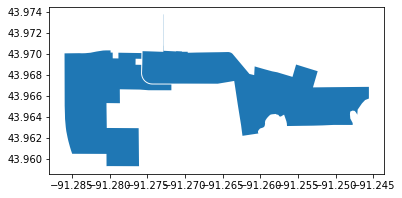

In [39]:
exploded = holmen2.explode()
exploded = exploded.reset_index(drop=True)
display(exploded)
exploded.plot()

<AxesSubplot:>

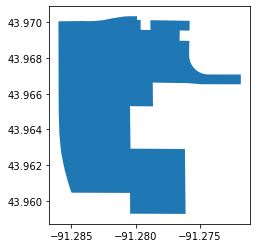

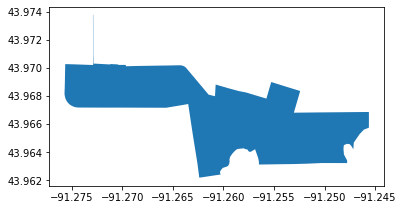

In [40]:
holmen2 = exploded.loc[0:0]
holland = exploded.loc[1:1]
holland.plot()
holmen2.plot()

In [41]:
#Assign values to Holland 1 to match VEST Holland 1 entry
holland['MCD_FIPS'] = '5506335350'
holland['STR_WARDS'] = '0001'
holland['NAME'] = 'Holland'
holland['MUN_WARD'] = 'Holland_0001'
holland['GEOID'] = '55063353500001'
display(holland)

C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry
1,2605,2605,1141,820,1046,15,7,66,6,1,0,0,775,6,3,34,2,0,0,0,271.0,277.0,3.0,23.0,6.0,6.0,272.0,287.0,21.0,0.0,La Crosse,Holland_0001,0001,Holland,La Crosse,47,55063,55063353500001,5506335350,94,32,3,35450,"POLYGON ((-91.27616 43.96290, -91.27611 43.959..."


In [42]:
#VEST says that they used an allocation method specified by the LTSB, but we could not locate that method, so we assigned all of the values to 0 and left the data in Holmen 2

keep = ['OBJECTID_1','OBJECTID','COUNTY','MUN_WARD','STR_WARDS','NAME','CNTY_NAME','LSAD','CNTY_FIPS','GEOID','MCD_FIPS','ASM','SEN','CON','COUSUBFP','WARD','PRECINCT','geometry']
for i in holland.columns:
    if i not in keep:
        holland[i] = holland[i].astype(int)
        holland[i] = 0
holland.head()

C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry
1,2605,2605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,La Crosse,Holland_0001,0001,Holland,La Crosse,47,55063,55063353500001,5506335350,94,32,3,35450,"POLYGON ((-91.27616 43.96290, -91.27611 43.959..."


In [43]:
# Remove the original Holmen 2
wards_drop_h2 = wards_add_cl10_m42[~wards_add_cl10_m42['MUN_WARD'].isin(['Holmen_0002'])].copy()

#Add Holland 1 and Holmen 2 back to the wards shapefile
wards_add_h2 = gp.GeoDataFrame(pd.concat([holmen2,holland,wards_drop_h2]),crs = proj)
wards.head()

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,geometry
0,3001,3001,55073545000005,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0005,604,454,579,6,14,1,4,0,0,0,442,0,8,1,3,0,0,0,219.0,129.0,4.0,10.0,3.0,4.0,201.0,148.0,16.0,1.0,"POLYGON ((-89.72744 44.78966, -89.72716 44.789..."
1,3002,3002,55073545000006,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0006,567,434,542,1,6,7,8,0,3,0,425,0,1,2,5,0,1,0,179.0,109.0,2.0,8.0,5.0,1.0,172.0,118.0,11.0,0.0,"POLYGON ((-89.66177 44.80774, -89.65977 44.807..."
2,3003,3003,55073545000007,5507354500,55073,25,Mosinee,86,29,7,54500,Marathon,0007,274,220,266,0,8,0,0,0,0,0,217,0,3,0,0,0,0,0,87.0,53.0,1.0,4.0,3.0,4.0,84.0,57.0,5.0,0.0,"POLYGON ((-89.65974 44.78602, -89.64965 44.786..."
3,3004,3004,55073545250001,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0001,778,585,737,4,33,2,1,0,0,1,563,2,16,2,1,0,0,1,283.0,147.0,3.0,15.0,3.0,4.0,281.0,153.0,17.0,1.0,"POLYGON ((-89.73299 44.80565, -89.73256 44.804..."
4,3005,3005,55073545250002,5507354525,55073,43,Mosinee,86,29,7,54525,Marathon,0002,842,632,812,5,10,10,5,0,0,0,618,2,2,7,3,0,0,0,305.0,158.0,2.0,15.0,3.0,2.0,303.0,164.0,17.0,0.0,"POLYGON ((-89.69059 44.85834, -89.69063 44.857..."


In [44]:
# Check the totals again 

# Get the total dictionaries for the elec data and the VEST data and compare

wards_tot = get_column_totals(wards_add_h2)
final_tot = get_column_totals(final)
matching = wards_tot == final_tot
print(wards_tot)
print(final_tot)
print('Do the election result sums match the VEST sums? ', str(matching))

{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
Do the election result sums match the VEST sums?  True


In [92]:
#Split Platteville 8 and and 9 based on VEST documentation

p8 = wards_add_h2[wards_add_h2['MUN_WARD']=='Platteville_0008'].copy()
display(p8)

,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry
1795,1962,1962,1819,1569,1678,57,35,30,10,1,1,7,1471,40,22,24,6,1,1,4,405.0,481.0,8.0,101.0,10.0,18.0,474.0,481.0,41.0,0.0,Grant,Platteville_0008,0008,Platteville,Grant,25,55043,55043632500008,5504363250,49,17,3,63250,"MULTIPOLYGON (((-90.42967 42.73649, -90.43113 ..."


,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry
0,1962,1962,1819,1569,1678,57,35,30,10,1,1,7,1471,40,22,24,6,1,1,4,405.0,481.0,8.0,101.0,10.0,18.0,474.0,481.0,41.0,0.0,Grant,Platteville_0008,0008,Platteville,Grant,25,55043,55043632500008,5504363250,49,17,3,63250,"POLYGON ((-90.42967 42.73649, -90.43113 42.736..."
1,1962,1962,1819,1569,1678,57,35,30,10,1,1,7,1471,40,22,24,6,1,1,4,405.0,481.0,8.0,101.0,10.0,18.0,474.0,481.0,41.0,0.0,Grant,Platteville_0008,0008,Platteville,Grant,25,55043,55043632500008,5504363250,49,17,3,63250,"POLYGON ((-90.44578 42.70389, -90.44573 42.701..."


<AxesSubplot:>

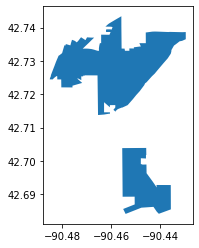

In [94]:
# Explode Plateville 8 into two separate polygons

exploded = p8.explode()
exploded = exploded.reset_index(drop=True)
display(exploded)
p8.plot()

<AxesSubplot:>

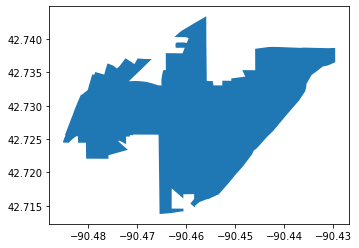

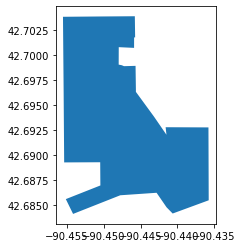

In [47]:
#Plot the polygons to determine which should be Platteville 8 and 9, to match VEST
p8 = exploded.loc[0:0]
p9 = exploded.loc[1:1]
p8.plot()
p9.plot()

In [48]:
# Assign values to Platteville 9 to match VEST
p9['STR_WARDS'] = '0009'
p9['MUN_WARD'] = 'Platteville_0009'
p9['GEOID'] = '55043632500009'
keep_vals = ['OBJECTID_1','OBJECTID','COUNTY','MUN_WARD','STR_WARDS','NAME','CNTY_NAME','LSAD','CNTY_FIPS','GEOID','MCD_FIPS','ASM','SEN','CON','COUSUBFP','WARD','PRECINCT','geometry']
for i in p9.columns:
    if i not in keep_vals:
        p9[i] = 0
display(p9)

C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry
1,1962,1962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Grant,Platteville_0009,0009,Platteville,Grant,25,55043,55043632500009,5504363250,49,17,3,63250,"POLYGON ((-90.44578 42.70389, -90.44573 42.701..."


In [49]:
# Remove the original Platteville 8
wards_drop_p8 = wards_add_h2[~wards_add_h2['MUN_WARD'].isin(['Platteville_0008'])].copy()

# Add back Platteveille 8 and 9
wards_add_p8p9 = gp.GeoDataFrame(pd.concat([p8,p9,wards_drop_p8]),crs = proj)

wards_add_p8p9.head()

,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry
0,1962,1962,1819,1569,1678,57,35,30,10,1,1,7,1471,40,22,24,6,1,1,4,405.0,481.0,8.0,101.0,10.0,18.0,474.0,481.0,41.0,0.0,Grant,Platteville_0008,0008,Platteville,Grant,25,55043,55043632500008,5504363250,49,17,3,63250,"POLYGON ((-90.42967 42.73649, -90.43113 42.736..."
1,1962,1962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Grant,Platteville_0009,0009,Platteville,Grant,25,55043,55043632500009,5504363250,49,17,3,63250,"POLYGON ((-90.44578 42.70389, -90.44573 42.701..."
0,2605,2605,1141,820,1046,15,7,66,6,1,0,0,775,6,3,34,2,0,0,0,271.0,277.0,3.0,23.0,6.0,6.0,272.0,287.0,21.0,0.0,La Crosse,Holmen_0002,0002,Holmen,La Crosse,47,55063,55063354500002,5506335450,94,32,3,35450,"POLYGON ((-91.27288 43.97377, -91.27286 43.971..."
1,2605,2605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,La Crosse,Holland_0001,0001,Holland,La Crosse,47,55063,55063353500001,5506335350,94,32,3,35450,"POLYGON ((-91.27616 43.96290, -91.27611 43.959..."
0,3105,3105,726,617,698,2,11,2,13,0,0,0,599,2,7,1,8,0,0,0,315.0,125.0,3.0,7.0,5.0,0.0,301.0,132.0,23.0,0.0,Marinette,Amberg_0001,0001,Amberg,Marinette,43,55075,55075016750001,5507501675,36,12,8,01675,"POLYGON ((-87.80506 45.53815, -87.80477 45.535..."


In [50]:
# Get the total dictionaries for the elec data and the VEST data and compare

wards_tot = get_column_totals(wards_add_p8p9)
final_tot = get_column_totals(final)
matching = wards_tot == final_tot
print(wards_tot)
print(final_tot)
print('Do the election result sums match the VEST sums? ', str(matching))
wards_mod = wards_add_p8p9

{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
Do the election result sums match the VEST sums?  True


In [51]:
# Make string modifications based on VEST documentation

#Rename Watertown 3 to 19
wards_mod['STR_WARDS'] = wards_mod.apply(lambda x: x['STR_WARDS'].replace('0003','0019') if x['NAME']=='Watertown' and x['COUNTY']=='Jefferson' else x['STR_WARDS'], axis=1)
wards_mod['WARD'] = wards_mod['STR_WARDS'].apply(lambda x: x.lstrip('0'))
wards_mod['WARD'] = wards_mod['WARD'].astype(str)

In [52]:
#Rename Fox Crossing to Menasha per VEST documentation
wards_mod['NAME'] = wards_mod.apply(lambda x: 'Menasha' if x['NAME']=='Fox Crossing' and x['WARD'] in ['8','9','10','11','12','13'] else x['NAME'],axis=1)
wards_mod['MCD_FIPS'] = wards_mod.apply(lambda x: '5513950850' if x['NAME']=='Menasha' and x['WARD'] in ['8','9','10','11','12','13'] and x['COUSUBFP']=='26982' else x['MCD_FIPS'], axis=1)
wards_mod['MCD_FIPS'] = wards_mod['MCD_FIPS'].astype(str)

wards_mod['NAME'] = wards_mod['NAME'].astype(str)
wards_mod['CNTY_NAME'] = wards_mod['CNTY_NAME'].astype(str)
wards_mod['GEOID'] = wards_mod.apply(lambda x: ''.join([x['MCD_FIPS'],x['STR_WARDS']]),axis=1)
wards_mod['GEOID'] = wards_mod.apply(lambda x: ''.join([x['CNTY_FIPS'],x['GEOID']]) if x['CNTY_FIPS'] not in x['GEOID'] else x['GEOID'], axis=1)

In [53]:
# Modify VEST file to recreate a GEOID field
final['GEOID'] = final.apply(lambda x: ''.join([x['MCD_FIPS'],x['STR_WARDS']]),axis=1)

In [54]:
print('Is there a unique field in the wards shapefile? (T/F) ', str(wards_mod['GEOID'].nunique()==wards_mod.shape[0]))
print('Is there a unique field in the final shapefile? (T/F) ', str(final['GEOID'].nunique()==final.shape[0]))
matching = final.shape[0] == wards_mod.shape[0]
print('Do the modified wards shapefile and the VEST shapefile have the same number of wards? (T/F)', str(matching))
if matching==True:
    print('Each dataset has ', final.shape[0], ' wards.')

Is there a unique field in the wards shapefile? (T/F)  True
Is there a unique field in the final shapefile? (T/F)  True
Do the modified wards shapefile and the VEST shapefile have the same number of wards? (T/F) True
Each dataset has  6872  wards.


In [55]:
# Get the total dictionaries for the elec data and the VEST data and compare

wards_tot = get_column_totals(wards_mod)
final_tot = get_column_totals(final)
matching = wards_tot == final_tot
print(wards_tot)
print(final_tot)
print('Do the election result sums match the VEST sums? ', str(matching))

{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
{'G16PRERTRU': 1405284.0, 'G16PREDCLI': 1382536.0, 'G16PRECCAS': 12162.0, 'G16PRELJOH': 106674.0, 'G16PREGSTE': 31072.0, 'G16PREOTH': 38422.0, 'G16USSRJOH': 1479471.0, 'G16USSDFEI': 1380335.0, 'G16USSLAND': 87531.0, 'G16USSOTH': 1404.0}
Do the election result sums match the VEST sums?  True


# Validate the Data

In [56]:
# Test the join
test = pd.merge(wards_mod,final,how='outer',on='GEOID',indicator=True)

In [57]:
# See what was not joined successfully between the two files 

false = test[test['_merge']!='both'].copy()
display(false)

,OBJECTID_1_x,OBJECTID_x,PERSONS_x,PERSONS18_x,WHITE_x,BLACK_x,HISPANIC_x,ASIAN_x,AMINDIAN_x,PISLAND_x,OTHER_x,OTHERMLT_x,WHITE18_x,BLACK18_x,HISPANIC18_x,ASIAN18_x,AMINDIAN18_x,PISLAND18_x,OTHER18_x,OTHERMLT18_x,G16PRERTRU_x,G16PREDCLI_x,G16PRECCAS_x,G16PRELJOH_x,G16PREGSTE_x,G16PREOTH_x,G16USSRJOH_x,G16USSDFEI_x,G16USSLAND_x,G16USSOTH_x,COUNTY_x,MUN_WARD,STR_WARDS_x,NAME_x,CNTY_NAME_x,LSAD_x,CNTY_FIPS_x,GEOID,MCD_FIPS_x,ASM_x,SEN_x,CON_x,COUSUBFP_x,geometry_x,WARD,OBJECTID_1_y,OBJECTID_y,MCD_FIPS_y,CNTY_FIPS_y,LSAD_y,NAME_y,ASM_y,SEN_y,CON_y,COUSUBFP_y,CNTY_NAME_y,STR_WARDS_y,PERSONS_y,PERSONS18_y,WHITE_y,BLACK_y,HISPANIC_y,ASIAN_y,AMINDIAN_y,PISLAND_y,OTHER_y,OTHERMLT_y,WHITE18_y,BLACK18_y,HISPANIC18_y,ASIAN18_y,AMINDIAN18_y,PISLAND18_y,OTHER18_y,OTHERMLT18_y,G16PRERTRU_y,G16PREDCLI_y,G16PRECCAS_y,G16PRELJOH_y,G16PREGSTE_y,G16PREOTH_y,G16USSRJOH_y,G16USSDFEI_y,G16USSLAND_y,G16USSOTH_y,geometry_y,COUNTY_y,_merge


In [58]:
def sum_checker (df, column_List):
    """Checks the sums of different columns and prints out the maximum difference by column. 
    Assumes that the dataframe is the merged dataframe between RDH and the partner, with the same named election result
    columns, except RDH is _x and Partner is _y. 
    """
    list_max = 0
    for i in column_List:
        left_sum = df[i+"_x"].sum()
        right_sum = df[i+"_y"].sum()
        if (left_sum==right_sum):
            print("Column: ", i, " have the same sums")
            
        else:
            diff = abs(left_sum-right_sum)
            percent = abs(left_sum-right_sum)/left_sum
            print("Column: ", i)
            print("RDH sum is ", str(left_sum))
            print("Partner sum is ", str(right_sum))
            print("Their (absolute) difference is ",str(diff))
            print("As a percentage of DF1 this is ", str(round(percent*100,5)) + "%")
            if (percent>list_max):
                list_max = percent
            print("")
    print("The max difference (as a percent of the total of one DF column) is: ", str(round(list_max,5)))

In [59]:
#Create a list of election result columns

col_list =[]
keep = ['OBJECTID_1','OBJECTID','COUNTY','MUN_WARD','STR_WARDS','NAME','CNTY_NAME','LSAD','CNTY_FIPS','GEOID','MCD_FIPS','ASM','SEN','CON','COUSUBFP','WARD','PRECINCT',
        'PERSONS', 'PERSONS18', 'WHITE', 'BLACK', 'HISPANIC', 'ASIAN', 'AMINDIAN', 'PISLAND', 'OTHER', 'OTHERMLT', 'WHITE18', 'BLACK18', 'HISPANIC18', 'ASIAN18', 'AMINDIAN18', 'PISLAND18', 'OTHER18', 'OTHERMLT18','geometry']
for i in wards.columns:
    if i not in keep:
        col_list.append(i)
print(col_list)

['G16PRERTRU', 'G16PREDCLI', 'G16PRECCAS', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOTH', 'G16USSRJOH', 'G16USSDFEI', 'G16USSLAND', 'G16USSOTH']


In [60]:
# Run the sum checker
sum_checker(test,col_list)

Column:  G16PRERTRU  have the same sums
Column:  G16PREDCLI  have the same sums
Column:  G16PRECCAS  have the same sums
Column:  G16PRELJOH  have the same sums
Column:  G16PREGSTE  have the same sums
Column:  G16PREOTH  have the same sums
Column:  G16USSRJOH  have the same sums
Column:  G16USSDFEI  have the same sums
Column:  G16USSLAND  have the same sums
Column:  G16USSOTH  have the same sums
The max difference (as a percent of the total of one DF column) is:  0


In [61]:
#Verify the results by precinct

def validater_row (df, column_List,match_col):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    diff_geoids = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                diff_geoids.append(df.iloc[j][match_col])
                same = False
                print('Different value for ', i, ' is ', diff, ' for ', df.iloc[j][match_col])
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j][match_col])
                if (diff>max_diff):
                    print("New max diff is: ", str(max_diff))
                    max_diff = diff
                    print(df.iloc[j][match_col])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j][match_col])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    print("The median difference is: ", str(np.median(diff_values)))
    return list(set(diff_geoids))

In [62]:

diff_ids = validater_row(test,col_list,'GEOID')

Different value for  G16PRERTRU  is  26.0  for  55063354500002
New max diff is:  0
55063354500002
Different value for  G16PREDCLI  is  27.0  for  55063354500002
New max diff is:  26.0
55063354500002
Different value for  G16PRELJOH  is  2.0  for  55063354500002
Different value for  G16PREOTH  is  1.0  for  55063354500002
Different value for  G16USSRJOH  is  26.0  for  55063354500002
Different value for  G16USSDFEI  is  28.0  for  55063354500002
New max diff is:  27.0
55063354500002
Different value for  G16USSLAND  is  3.0  for  55063354500002
Different value for  G16PRERTRU  is  44.0  for  55063353500001
New max diff is:  28.0
55063353500001
Different value for  G16PREDCLI  is  33.0  for  55063353500001
Different value for  G16PRECCAS  is  1.0  for  55063353500001
Different value for  G16PRELJOH  is  3.0  for  55063353500001
Different value for  G16PREGSTE  is  1.0  for  55063353500001
Different value for  G16PREOTH  is  1.0  for  55063353500001
Different value for  G16USSRJOH  is  46.0

Different value for  G16USSOTH  is  1.0  for  55139269820005
Different value for  G16PRERTRU  is  252.0  for  55139269820006
New max diff is:  218.0
55139269820006
Different value for  G16PREDCLI  is  184.0  for  55139269820006
Different value for  G16PRECCAS  is  2.0  for  55139269820006
Different value for  G16PRELJOH  is  22.0  for  55139269820006
Different value for  G16PREGSTE  is  5.0  for  55139269820006
Different value for  G16PREOTH  is  7.0  for  55139269820006
Different value for  G16USSRJOH  is  281.0  for  55139269820006
New max diff is:  252.0
55139269820006
Different value for  G16USSDFEI  is  175.0  for  55139269820006
Different value for  G16USSLAND  is  14.0  for  55139269820006
Different value for  G16USSOTH  is  1.0  for  55139269820006
Different value for  G16PRERTRU  is  246.0  for  55139269820007
Different value for  G16PREDCLI  is  171.0  for  55139269820007
Different value for  G16PRECCAS  is  2.0  for  55139269820007
Different value for  G16PRELJOH  is  27.0  

In [68]:
#Subset the joined dataset by those with mismatching election values

not_matching = test[test['GEOID'].isin(diff_ids)].copy()
print('Counties with mismatching data are: ', str(', '.join(list(not_matching['COUNTY_y'].unique()))))
not_matching['precinct'] = not_matching.apply(lambda x: '_'.join([x['NAME_y'],x['STR_WARDS_y'],x['COUNTY_y']]),axis=1)
print('\nPrecinct with mismatching data are: ', ', '.join(sorted(list(not_matching['precinct'].unique()))))
print('\nThere are ', len(not_matching), ' wards that have at least one mismatched election result.')

Counties with mismatching data are:  La Crosse, Winnebago

Precinct with mismatching data are:  Fox Crossing_0001_Winnebago, Fox Crossing_0002_Winnebago, Fox Crossing_0003_Winnebago, Fox Crossing_0004_Winnebago, Fox Crossing_0005_Winnebago, Fox Crossing_0006_Winnebago, Fox Crossing_0007_Winnebago, Holland_0001_La Crosse, Holland_0002_La Crosse, Holland_0003_La Crosse, Holland_0004_La Crosse, Holland_0005_La Crosse, Holland_0006_La Crosse, Holmen_0001_La Crosse, Holmen_0002_La Crosse, Holmen_0003_La Crosse, Holmen_0004_La Crosse, Holmen_0005_La Crosse, Holmen_0006_La Crosse, Holmen_0007_La Crosse, Holmen_0008_La Crosse, Holmen_0009_La Crosse, Holmen_0010_La Crosse, Holmen_0011_La Crosse, Menasha_0008_Winnebago, Menasha_0009_Winnebago, Menasha_0010_Winnebago, Menasha_0011_Winnebago, Menasha_0012_Winnebago, Menasha_0013_Winnebago

There are  30  wards that have at least one mismatched election result.


In [66]:
# View not matching precincts

display(not_matching)

,OBJECTID_1_x,OBJECTID_x,PERSONS_x,PERSONS18_x,WHITE_x,BLACK_x,HISPANIC_x,ASIAN_x,AMINDIAN_x,PISLAND_x,OTHER_x,OTHERMLT_x,WHITE18_x,BLACK18_x,HISPANIC18_x,ASIAN18_x,AMINDIAN18_x,PISLAND18_x,OTHER18_x,OTHERMLT18_x,G16PRERTRU_x,G16PREDCLI_x,G16PRECCAS_x,G16PRELJOH_x,G16PREGSTE_x,G16PREOTH_x,G16USSRJOH_x,G16USSDFEI_x,G16USSLAND_x,G16USSOTH_x,COUNTY_x,MUN_WARD,STR_WARDS_x,NAME_x,CNTY_NAME_x,LSAD_x,CNTY_FIPS_x,GEOID,MCD_FIPS_x,ASM_x,SEN_x,CON_x,COUSUBFP_x,geometry_x,WARD,OBJECTID_1_y,OBJECTID_y,MCD_FIPS_y,CNTY_FIPS_y,LSAD_y,NAME_y,ASM_y,SEN_y,CON_y,COUSUBFP_y,CNTY_NAME_y,STR_WARDS_y,PERSONS_y,PERSONS18_y,WHITE_y,BLACK_y,HISPANIC_y,ASIAN_y,AMINDIAN_y,PISLAND_y,OTHER_y,OTHERMLT_y,WHITE18_y,BLACK18_y,HISPANIC18_y,ASIAN18_y,AMINDIAN18_y,PISLAND18_y,OTHER18_y,OTHERMLT18_y,G16PRERTRU_y,G16PREDCLI_y,G16PRECCAS_y,G16PRELJOH_y,G16PREGSTE_y,G16PREOTH_y,G16USSRJOH_y,G16USSDFEI_y,G16USSLAND_y,G16USSOTH_y,geometry_y,COUNTY_y,_merge,precinct
2,2605,2605,1141,820,1046,15,7,66,6,1,0,0,775,6,3,34,2,0,0,0,271.0,277.0,3.0,23.0,6.0,6.0,272.0,287.0,21.0,0.0,La Crosse,Holmen_0002,0002,Holmen,La Crosse,47,55063,55063354500002,5506335450,94,32,3,35450,"POLYGON ((-91.27288 43.97377, -91.27286 43.971...",2,2605,2605,5506335450,55063,47,Holmen,94,32,3,35450,La Crosse,0002,1013,736,925,15,7,66,0,0,0,0,693,6,3,34,0,0,0,0,245.0,250.0,3.0,21.0,6.0,7.0,246.0,259.0,18.0,0.0,"POLYGON ((-91.27288 43.97377, -91.27286 43.971...",La Crosse,both,Holmen_0002_La Crosse
3,2605,2605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,La Crosse,Holland_0001,0001,Holland,La Crosse,47,55063,55063353500001,5506335350,94,32,3,35450,"POLYGON ((-91.27616 43.96290, -91.27611 43.959...",1,2605,2605,5506335350,55063,47,Holland,94,32,3,35450,La Crosse,0001,128,84,121,0,0,0,6,1,0,0,82,0,0,0,2,0,0,0,44.0,33.0,1.0,3.0,1.0,1.0,46.0,34.0,2.0,0.0,"POLYGON ((-91.27616 43.96290, -91.27611 43.959...",La Crosse,both,Holland_0001_La Crosse
5401,2599,2599,581,391,551,3,5,18,3,0,1,0,375,2,2,9,3,0,0,0,207.0,152.0,3.0,16.0,3.0,4.0,213.0,157.0,11.0,0.0,La Crosse,Holland_0002,0002,Holland,La Crosse,43,55063,55063353500002,5506335350,94,32,3,35350,"POLYGON ((-91.27288 43.97377, -91.27290 43.973...",2,2599,2599,5506335350,55063,43,Holland,94,32,3,35350,La Crosse,0002,581,391,551,3,5,18,3,0,1,0,375,2,2,9,3,0,0,0,201.0,147.0,3.0,16.0,3.0,5.0,206.0,152.0,11.0,0.0,"POLYGON ((-91.27288 43.97377, -91.27290 43.973...",La Crosse,both,Holland_0002_La Crosse
5402,2600,2600,928,640,874,3,1,47,1,1,0,1,612,0,1,25,1,0,0,1,332.0,243.0,5.0,25.0,5.0,7.0,341.0,252.0,18.0,0.0,La Crosse,Holland_0003,0003,Holland,La Crosse,43,55063,55063353500003,5506335350,94,32,3,35350,"POLYGON ((-91.29039 43.98446, -91.29037 43.983...",3,2600,2600,5506335350,55063,43,Holland,94,32,3,35350,La Crosse,0003,928,640,874,3,1,47,1,1,0,1,612,0,1,25,1,0,0,1,321.0,235.0,6.0,25.0,6.0,9.0,330.0,244.0,18.0,0.0,"POLYGON ((-91.29039 43.98446, -91.29037 43.983...",La Crosse,both,Holland_0003_La Crosse
5403,2601,2601,992,728,951,2,8,28,2,0,1,0,703,2,3,17,2,0,1,0,355.0,260.0,6.0,28.0,6.0,10.0,366.0,270.0,20.0,0.0,La Crosse,Holland_0004,0004,Holland,La Crosse,43,55063,55063353500004,5506335350,94,32,3,35350,"POLYGON ((-91.29108 44.06258, -91.29108 44.061...",4,2601,2601,5506335350,55063,43,Holland,94,32,3,35350,La Crosse,0004,992,728,951,2,8,28,2,0,1,0,703,2,3,17,2,0,1,0,343.0,251.0,6.0,27.0,6.0,9.0,352.0,260.0,19.0,0.0,"POLYGON ((-91.29108 44.06258, -91.29108 44.061...",La Crosse,both,Holland_0004_La Crosse
5404,2602,2602,817,611,769,6,7,30,5,0,0,0,580,1,6,19,5,0,0,0,293.0,215.0,6.0,23.0,6.0,9.0,301.0,222.0,17.0,0.0,La Crosse,Holland_0005,0005,Holland,La Crosse,43,55063,55063353500005,5506335350,94,32,3,35350,"POLYGON ((-91.21186 44.06794, -91.21186 44.067...",5,2602,2602,5506335350,55063,43,Holland,94,32,3,35350,La Crosse,0005,817,611,769,6,7,30,5,0,0,0,580,1,6,19,5,0,0,0,282.0,207.0,5.0,22.0,5.0,7.0,290.0,214.0,16.0,0.0,"POLYGON ((-91.21186 44.06794, -91.21186 44.067...",La Crosse,both,Holland_0005_La Crosse
5405,2603,2603,241,18

In [69]:
def validate_geom(gdf1,gdf2,sort_field,proj_epsg,dec=0):
    gdf1["geometry"]=gdf1.buffer(0) #buffer by 0 to remove any non polygons
    gdf2["geometry"]=gdf2.buffer(0)
    proj = gdf1.crs #project to same projection
    gdf2 = gdf2.to_crs(proj)
    gdf1 = gdf1.to_crs(proj)
    gdf1 = gdf1.sort_values(by=[sort_field]) #sort values by the unique field
    gdf2 = gdf2.sort_values(by=[sort_field])
    gdf2.reset_index(drop=True,inplace=True) #drop the index
    gdf1.reset_index(drop=True,inplace=True)
    ###Add in print link difference between the two files
    ## Look at GA example
    #see the difference between the precinct and final file
    ngdf1 = gdf1.to_crs(epsg=proj_epsg)
    ngdf2 = gdf2.to_crs(epsg=proj_epsg)
    ngdf1 = ngdf1.buffer(0)
    ngdf2 = ngdf2.buffer(0)
    file = ngdf2.difference(ngdf1)
    print('Difference between gdf1 and gdf2 as a percent of gdf1 total area ', str((sum(file.area)/sum(ngdf1.area))*100))
    print('Difference between gdf1 and gdf2 as a percent of gdf2 total area ', str((sum(file.area)/sum(ngdf2.area))*100))
    #To 6 decimal places, the two files are equal 
    t_f_geom = list(gdf1.geom_almost_equals(gdf2,decimal=dec))
    gdf1['GEOM_EQUALS'] = t_f_geom
    gdf2['GEOM_EQUALS'] = t_f_geom
    gdf1_not_match = gdf1[gdf1['GEOM_EQUALS']==False]
    gdf2_not_match = gdf2[gdf2['GEOM_EQUALS']==False]
    gdf1_not_match = gdf1_not_match.to_crs(epsg=proj_epsg)
    gdf2_not_match = gdf1_not_match.to_crs(epsg=proj_epsg)
    gdf1_not_match.buffer(0)
    gdf2_not_match.buffer(0)
    file2 = gdf1_not_match.difference(gdf2_not_match)
    print('Difference between not matching precincts in gdf1 and not matching precincts in gdf2 as a percent of gdf1 not matching precincts total area ', str((sum(file2.area)/sum(gdf1_not_match.area))*100))
    print('Difference between not matching precincts in gdf2 and not matching precincts in gdf1 as a percent of gdf2 not matching precincts total area ', str((sum(file2.area)/sum(gdf2_not_match.area))*100))
    unique_geom = []
    for i in t_f_geom:
        if i not in unique_geom:
            unique_geom.append(i)
    for i in unique_geom:
        percent = str((t_f_geom.count(i)/len(t_f_geom))*100) 
        print(str(t_f_geom.count(i)) + ' precincts are ' + str(i) + ' which is ' + percent + ' percent of all precincts.')
    return gdf1, gdf2

In [70]:
geom_validate1 = validate_geom(final,wards_mod,'GEOID',2288)

Difference between gdf1 and gdf2 as a percent of gdf1 total area  0.0003100637127274496
Difference between gdf1 and gdf2 as a percent of gdf2 total area  0.00031006367444897715
Difference between not matching precincts in gdf1 and not matching precincts in gdf2 as a percent of gdf1 not matching precincts total area  0.0
Difference between not matching precincts in gdf2 and not matching precincts in gdf1 as a percent of gdf2 not matching precincts total area  0.0
6860 precincts are True which is 99.82537834691502 percent of all precincts.
12 precincts are False which is 0.17462165308498254 percent of all precincts.


In [71]:
vest_false = geom_validate1[0][geom_validate1[0]['GEOM_EQUALS']==False].copy()
display(vest_false)

,OBJECTID_1,OBJECTID,GEOID,MCD_FIPS,CNTY_FIPS,LSAD,NAME,ASM,SEN,CON,COUSUBFP,CNTY_NAME,STR_WARDS,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,geometry,COUNTY,GEOM_EQUALS
611,613,613,55019001000005,5501900100,55019,25,Abbotsford,69,23,7,00100,Clark,0005,371,280,273,3,93,1,1,0,0,0,219,2,57,1,1,0,0,0,86.0,54.0,1.0,4.0,2.0,2.0,84.0,56.0,6.0,0.0,"POLYGON ((-90.31662 44.94497, -90.31665 44.943...",Clark,False
617,620,620,55019161750001,5501916175,55019,43,Colby,69,23,7,16175,Clark,0001,22,18,22,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,4.0,2.0,0.0,0.0,0.0,0.0,5.0,2.0,1.0,0.0,"POLYGON ((-90.32083 44.94195, -90.32085 44.938...",Clark,False
618,621,621,55019161750002,5501916175,55019,43,Colby,69,23,7,16175,Clark,0002,650,437,611,4,27,4,4,0,0,0,412,1,18,2,4,0,0,0,132.0,58.0,2.0,7.0,0.0,5.0,126.0,63.0,11.0,0.0,"POLYGON ((-90.33668 44.94289, -90.33669 44.941...",Clark,False
2042,2048,2048,55047101250001,5504710125,55047,43,Brooklyn,41,14,6,10125,Green Lake,0001,962,789,935,3,10,7,2,2,1,2,775,1,6,3,2,1,1,0,386.0,171.0,3.0,20.0,4.0,11.0,412.0,160.0,18.0,0.0,"MULTIPOLYGON (((-88.92602 43.80760, -88.92591 ...",Green Lake,False
2237,2244,2244,55055383500003,5505538350,55055,47,Johnson Creek,38,13,5,38350,Jefferson,0003,920,684,837,12,40,20,6,0,5,0,635,6,24,14,2,0,3,0,284.0,187.0,4.0,23.0,3.0,11.0,298.0,193.0,12.0,1.0,"POLYGON ((-88.76222 43.06495, -88.76221 43.066...",Jefferson,False
2245,2252,2252,55055416750001,5505541675,55055,25,Lake Mills,38,13,5,41675,Jefferson,0001,990,784,942,7,30,10,1,0,0,0,759,1,17,6,1,0,0,0,242.0,290.0,2.0,26.0,9.0,12.0,257.0,301.0,18.0,1.0,"MULTIPOLYGON (((-88.91452 43.08381, -88.91579 ...",Jefferson,False
2247,2254,2254,55055416750003,5505541675,55055,25,Lake Mills,38,13,5,41675,Jefferson,0003,918,711,884,4,23,7,0,0,0,0,695,3,10,3,0,0,0,0,223.0,268.0,1.0,24.0,8.0,8.0,237.0,278.0,16.0,0.0,"POLYGON ((-88.91402 43.05888, -88.91804 43.058...",Jefferson,False
2253,2260,2260,55055417000001,5505541700,55055,43,Lake Mills,38,13,5,41700,Jefferson,0001,829,633,808,0,10,2,9,0,0,0,619,0,8,2,4,0,0,0,224.0,230.0,1.0,19.0,4.0,11.0,246.0,237.0,9.0,0.0,"POLYGON ((-88.92483 43.09682, -88.92462 43.096...",Jefferson,False
2288,2284,2284,55055839750019,5505583975,55055,25,Watertown,38,13,5,83975,Jefferson,0019,2,2,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-88.76506 43.19123, -88.76414 43.191...",Jefferson,False
3851,3862,3862,55081801000001,5508180100,55081,43,Tomah,96,32,3,80100,Monroe,0001,625,473,604,4,5,8,3,0,1,0,459,2,3,5,3,0,1,0,220.0,108.0,5.0,11.0,3.0,2.0,214.0,116.0,14.0,0.0,"POLYGON ((-90.55166 43.89920, -90.55168 43.902...",Monroe,False


In [72]:
rdh_false = geom_validate1[1][geom_validate1[1]['GEOM_EQUALS']==False].copy()
display(rdh_false)

,OBJECTID_1,OBJECTID,PERSONS,PERSONS18,WHITE,BLACK,HISPANIC,ASIAN,AMINDIAN,PISLAND,OTHER,OTHERMLT,WHITE18,BLACK18,HISPANIC18,ASIAN18,AMINDIAN18,PISLAND18,OTHER18,OTHERMLT18,G16PRERTRU,G16PREDCLI,G16PRECCAS,G16PRELJOH,G16PREGSTE,G16PREOTH,G16USSRJOH,G16USSDFEI,G16USSLAND,G16USSOTH,COUNTY,MUN_WARD,STR_WARDS,NAME,CNTY_NAME,LSAD,CNTY_FIPS,GEOID,MCD_FIPS,ASM,SEN,CON,COUSUBFP,geometry,WARD,GEOM_EQUALS
611,613,613,371,280,273,3,93,1,1,0,0,0,219,2,57,1,1,0,0,0,86.0,54.0,1.0,4.0,2.0,2.0,84.0,56.0,6.0,0.0,Clark,Abbotsford_0005,0005,Abbotsford,Clark,25,55019,55019001000005,5501900100,69,23,7,00100,"POLYGON ((-90.31662 44.94572, -90.31662 44.945...",5,False
617,620,620,22,18,22,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,4.0,2.0,0.0,0.0,0.0,0.0,5.0,2.0,1.0,0.0,Clark,Colby_0001,0001,Colby,Clark,43,55019,55019161750001,5501916175,69,23,7,16175,"MULTIPOLYGON (((-90.33027 44.93900, -90.32943 ...",1,False
618,621,621,650,437,611,4,27,4,4,0,0,0,412,1,18,2,4,0,0,0,132.0,58.0,2.0,7.0,0.0,5.0,126.0,63.0,11.0,0.0,Clark,Colby_0002,0002,Colby,Clark,43,55019,55019161750002,5501916175,69,23,7,16175,"POLYGON ((-90.33671 44.94542, -90.33669 44.945...",2,False
2042,2048,2048,962,789,935,3,10,7,2,2,1,2,775,1,6,3,2,1,1,0,386.0,171.0,3.0,20.0,4.0,11.0,412.0,160.0,18.0,0.0,Green Lake,Brooklyn_0001,0001,Brooklyn,Green Lake,43,55047,55047101250001,5504710125,41,14,6,10125,"MULTIPOLYGON (((-88.92602 43.80760, -88.92591 ...",1,False
2237,2244,2244,920,684,837,12,40,20,6,0,5,0,635,6,24,14,2,0,3,0,284.0,187.0,4.0,23.0,3.0,11.0,298.0,193.0,12.0,1.0,Jefferson,Johnson Creek_0003,0003,Johnson Creek,Jefferson,47,55055,55055383500003,5505538350,38,13,5,38350,"POLYGON ((-88.76222 43.06495, -88.76221 43.066...",3,False
2245,2252,2252,990,784,942,7,30,10,1,0,0,0,759,1,17,6,1,0,0,0,242.0,290.0,2.0,26.0,9.0,12.0,257.0,301.0,18.0,1.0,Jefferson,Lake Mills_0001,0001,Lake Mills,Jefferson,25,55055,55055416750001,5505541675,38,13,5,41675,"MULTIPOLYGON (((-88.92238 43.08421, -88.92238 ...",1,False
2247,2254,2254,918,711,884,4,23,7,0,0,0,0,695,3,10,3,0,0,0,0,223.0,268.0,1.0,24.0,8.0,8.0,237.0,278.0,16.0,0.0,Jefferson,Lake Mills_0003,0003,Lake Mills,Jefferson,25,55055,55055416750003,5505541675,38,13,5,41675,"POLYGON ((-88.92069 43.08079, -88.92068 43.080...",3,False
2253,2260,2260,829,633,808,0,10,2,9,0,0,0,619,0,8,2,4,0,0,0,224.0,230.0,1.0,19.0,4.0,11.0,246.0,237.0,9.0,0.0,Jefferson,Lake Mills_0001,0001,Lake Mills,Jefferson,43,55055,55055417000001,5505541700,38,13,5,41700,"POLYGON ((-88.92483 43.09682, -88.92462 43.096...",1,False
2288,2284,2284,2,2,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jefferson,Watertown_0003,0019,Watertown,0,25,55055,55055839750019,5505583975,0,0,0,83975,"MULTIPOLYGON (((-88.76506 43.19123, -88.76414 ...",19,False
3851,3862,3862,625,473,604,4,5,8,3,0,1,0,459,2,3,5,3,0,1,0,220.0,108.0,5.0,11.0,3.0,2.0,214.0,116.0,14.0,0.0,Monroe,Tomah_0001,0001,Tomah,Monroe,43,55081,55081801000001,5508180100,96,32,3,80100,"MULTIPOLYGON (((-90.55166 43.89920, -90.55168 ...",1,False


In [74]:
print(len(vest_false))
print(len(rdh_false))

12
12


<AxesSubplot:>

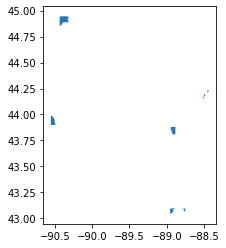

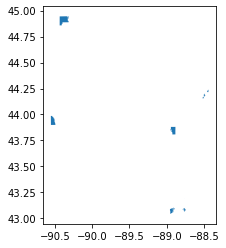

In [75]:
vest_false.plot()
rdh_false.plot()

In [89]:
def plot_geoms(gdf1,gdf2,col,espg):
    col_gdf1 = sorted(list(gdf1[col]))
    col_gdf2 = sorted(list(gdf2[col]))
    for k,v in dict(zip(col_gdf1,col_gdf2)).items():
        new_gdf1 = gdf1[gdf1[col]==k].copy()
        new_gdf2 = gdf2[gdf2[col]==v].copy()
        print('\nValidation for ', k)
        geom_validate1 = validate_geom(new_gdf1,new_gdf2,col,espg)
        new_gdf1.plot()
        new_gdf2.plot()
    


Validation for  55019001000005
Difference between gdf1 and gdf2 as a percent of gdf1 total area  94.64225595260447
Difference between gdf1 and gdf2 as a percent of gdf2 total area  48.62966413198468
Difference between not matching precincts in gdf1 and not matching precincts in gdf2 as a percent of gdf1 not matching precincts total area  0.0
Difference between not matching precincts in gdf2 and not matching precincts in gdf1 as a percent of gdf2 not matching precincts total area  0.0
1 precincts are False which is 100.0 percent of all precincts.

Validation for  55019161750001
Difference between gdf1 and gdf2 as a percent of gdf1 total area  0.21448676427569643
Difference between gdf1 and gdf2 as a percent of gdf2 total area  0.2582462061500484
Difference between not matching precincts in gdf1 and not matching precincts in gdf2 as a percent of gdf1 not matching precincts total area  0.0
Difference between not matching precincts in gdf2 and not matching precincts in gdf1 as a percent o

C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


Difference between gdf1 and gdf2 as a percent of gdf1 total area  0.0
Difference between gdf1 and gdf2 as a percent of gdf2 total area  0.0
Difference between not matching precincts in gdf1 and not matching precincts in gdf2 as a percent of gdf1 not matching precincts total area  0.0
Difference between not matching precincts in gdf2 and not matching precincts in gdf1 as a percent of gdf2 not matching precincts total area  0.0
1 precincts are False which is 100.0 percent of all precincts.


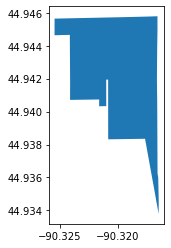

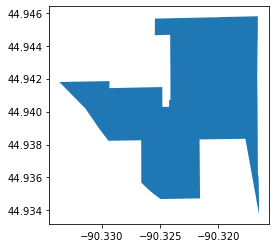

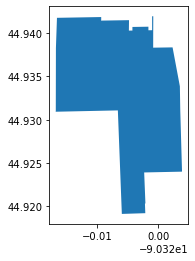

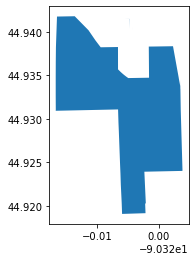

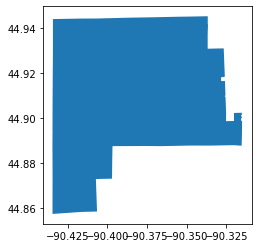

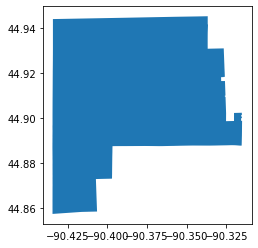

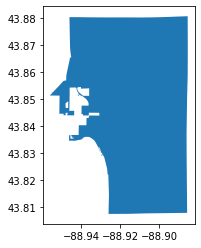

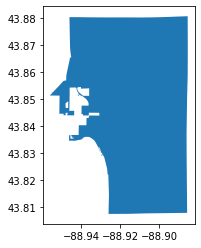

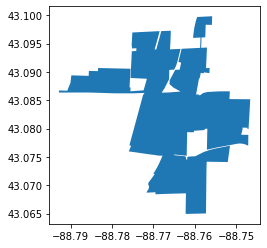

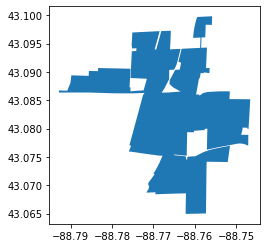

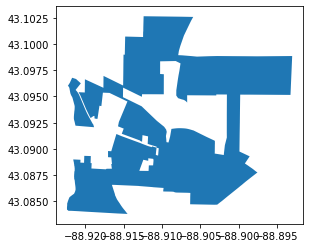

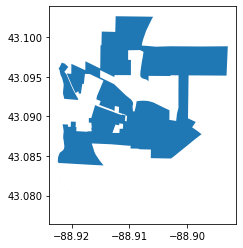

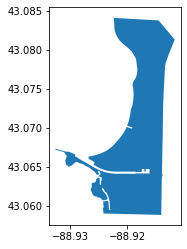

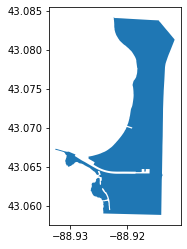

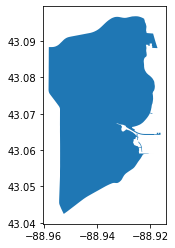

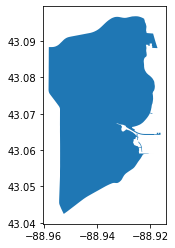

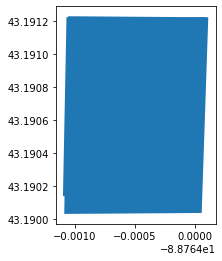

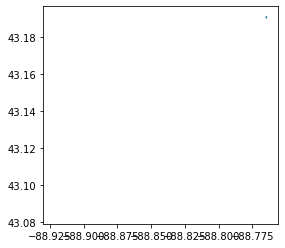

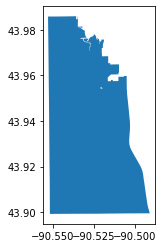

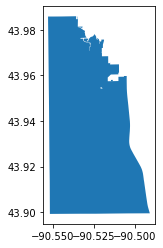

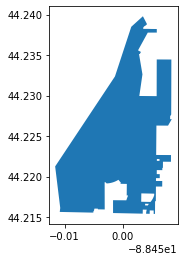

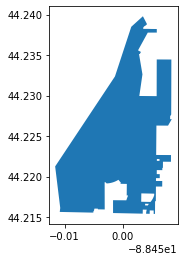

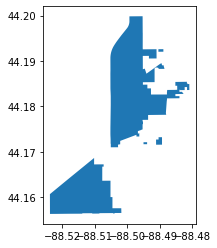

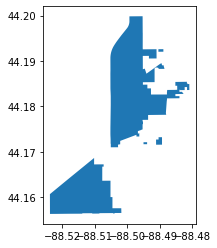

In [90]:
plot_geoms(vest_false,rdh_false,'GEOID',2288)